## Load libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,  StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Lasso

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# import os
# print(os.getcwd())

/Users/cherylsusan/dsa4263_project/src


In [3]:
# Load train and test data
train_df = pd.read_csv("../../data/train_data.csv")
test_df = pd.read_csv("../../data/test_data.csv")

In [4]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
scaler_train = StandardScaler()
numeric_cols_train = X_train.select_dtypes(include=['number'])
X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

scaler_test = StandardScaler()
numeric_cols_test = X_test.select_dtypes(include=['number'])
X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

### Undersampling majority class: Random Undersampling

In [5]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


### Oversampling minority class: SMOTE-NC

In [6]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-hot encoding (for random forest)

In [7]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
X_test_ohe = pd.get_dummies(X_test, drop_first = True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 543


### Feature selection

##### SelectKBest

In [8]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_kbest = selector.fit_transform(X_train_ohe,y_train_smote)
X_test_kbest = selector.transform(X_test_ohe)

##### Lasso

In [9]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_ohe, y_train_smote)
feature_importance = pd.Series(lasso.coef_, index=X_train_ohe.columns)
selected_features = feature_importance[feature_importance != 0].index.tolist()
X_train_lasso = X_train_ohe.loc[:, selected_features]
X_test_lasso = X_test_ohe.loc[:, selected_features]

##### RFECV

In [10]:
# Run RFECV with step = 0.1 first to narrow down to a rough figure
cv_split = StratifiedKFold(5, shuffle=True, random_state=123)
model = RandomForestClassifier(random_state=123)

rfecv_estimate = RFECV(
    estimator=model,
    step=0.1,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 1
)

rfecv_estimate.fit(X_train_ohe, y_train_smote)

print(f"Optimal number of features: {rfecv_estimate.n_features_}")

Fitting estimator with 543 features.
Fitting estimator with 543 features.
Fitting estimator with 543 features.
Fitting estimator with 543 features.
Fitting estimator with 543 features.
Fitting estimator with 489 features.
Fitting estimator with 489 features.
Fitting estimator with 489 features.
Fitting estimator with 489 features.
Fitting estimator with 489 features.
Fitting estimator with 435 features.
Fitting estimator with 435 features.
Fitting estimator with 435 features.
Fitting estimator with 435 features.
Fitting estimator with 435 features.
Fitting estimator with 381 features.
Fitting estimator with 381 features.
Fitting estimator with 381 features.
Fitting estimator with 381 features.
Fitting estimator with 381 features.
Fitting estimator with 327 features.
Fitting estimator with 327 features.
Fitting estimator with 327 features.
Fitting estimator with 327 features.
Fitting estimator with 327 features.
Fitting estimator with 273 features.
Fitting estimator with 273 features.
F

In [11]:
# Run RFECV again on selected features to further narrow down to more precise number of features

top_features = np.where(rfecv_estimate.support_)[0]
X_rfecv_estimate = X_train_ohe.iloc[:, top_features]

rfecv_fine = RFECV(estimator=model,
    step=5,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 2)
rfecv_fine.fit(X_rfecv_estimate, y_train_smote)

print(f"Optimal number of features: {rfecv_fine.n_features_}")

selected_columns = rfecv_fine.get_feature_names_out()
X_train_rfecv = X_train_ohe[selected_columns]
X_test_rfecv = X_test_ohe[selected_columns]

Fitting estimator with 57 features.
Fitting estimator with 57 features.
Fitting estimator with 57 features.
Fitting estimator with 57 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 37 features.
Fitting estimator with 37 features.
Fitting estimator with 37 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 32 fe

In [ ]:
print(selected_columns)

['city_pop' 'amt' 'hour' 'year' 'age' 'prev_trans_fraud'
 'count_fraud_7days' 'acc_fraud_count' 'merchant_prev_trans_fraud'
 'merchant_acc_fraud_count' 'hourly_risk_score' 'interval'
 'interval_deviation' 'visited_cat' 'category_first_purchase'
 'amt_deviation' 'category_grocery_pos']


17

In [ ]:
# # Run this cell to skip waiting for RFECV

selected_columns = ['city_pop' 'amt' 'hour' 'year' 'age' 'prev_trans_fraud'
 'count_fraud_7days' 'acc_fraud_count' 'merchant_prev_trans_fraud'
 'merchant_acc_fraud_count' 'hourly_risk_score' 'interval'
 'interval_deviation' 'visited_cat' 'category_first_purchase'
 'amt_deviation' 'category_grocery_pos']
X_train_rfecv = X_train_ohe[selected_columns]
X_test_rfecv = X_test_ohe[selected_columns]

## Base model

accuracy: 0.9952394005847953, precision: 0.9954244020590762, recall: 0.9938596491228071, f1: 0.9946358810390894
AUC: 0.99


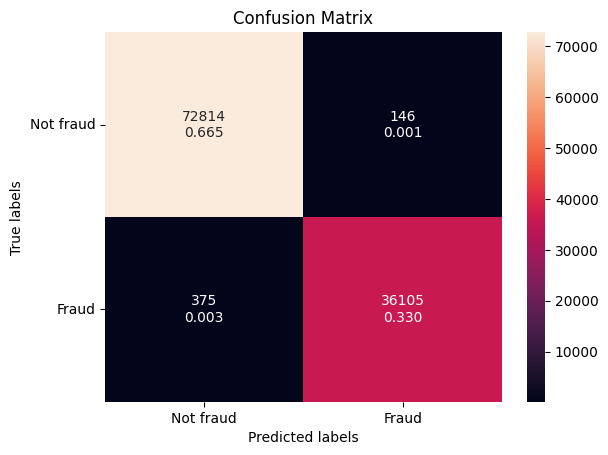

In [14]:
# SelectKBest

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation
y_pred_kbest = cross_val_predict(clf, X_train_kbest, y_train_smote, cv = sk_folds)

# Calculate scores
auc_kbest = roc_auc_score(y_train_smote, y_pred_kbest)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_kbest)}, precision: {precision_score(y_train_smote, y_pred_kbest, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_kbest, average='macro')}, f1: {f1_score(y_train_smote, y_pred_kbest, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_kbest, 2)}')

#Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_kbest)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9960434941520467, precision: 0.9960006660806612, recall: 0.995093201754386, f1: 0.9955448628469019
AUC: 1.0


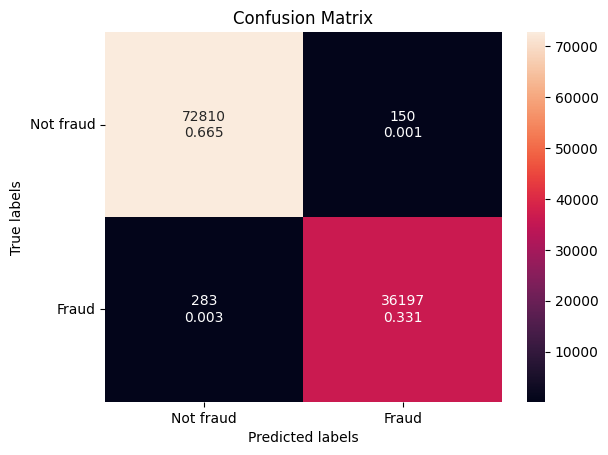

In [15]:
# Lasso

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso = cross_val_predict(clf, X_train_lasso, y_train_smote, cv = sk_folds)

# Run cross validation
auc_lasso = roc_auc_score(y_train_smote, y_pred_lasso)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso)}, precision: {precision_score(y_train_smote, y_pred_lasso, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_lasso, average='macro')}, f1: {f1_score(y_train_smote, y_pred_lasso, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_lasso, 2)}')

# Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_lasso)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9964089912280701, precision: 0.9963782947980059, recall: 0.9955386513157894, f1: 0.9959567011775328
AUC: 1.0


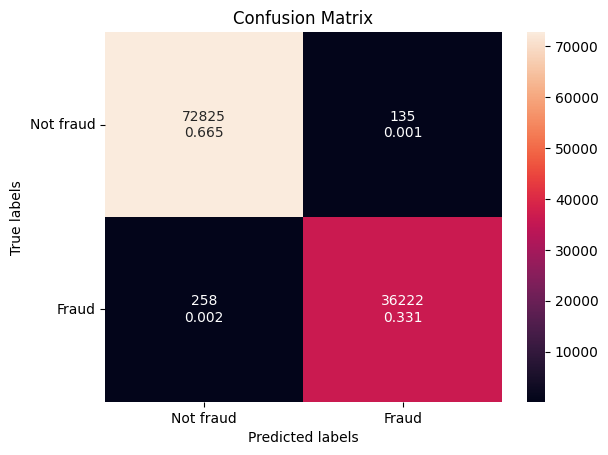

In [16]:
# RFECV

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation
y_pred_rfecv = cross_val_predict(clf, X_train_rfecv, y_train_smote, cv = sk_folds)

# Calculate scores
auc_rfecv = roc_auc_score(y_train_smote, y_pred_rfecv)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_rfecv)}, precision: {precision_score(y_train_smote, y_pred_rfecv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_rfecv, average='macro')}, f1: {f1_score(y_train_smote, y_pred_rfecv, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_rfecv, 2)}')

# Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_rfecv)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

## With GridSearchCV

In [17]:
# Apply GridSearchCV on random forest with RFECV to tune hyperparameters
clf2 = RandomForestClassifier(random_state=123)

params = {'n_estimators': [100, 150, 150], 
         'max_features': ['sqrt', 'log2', 20],
         'max_depth': [10, 15],
         'criterion': ['gini', 'entropy']}
cv = GridSearchCV(estimator = clf2, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'f1')

cv.fit(X_train_rfecv, y_train_smote)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  19.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  19.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  19.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  19.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  20.7s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  28.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  29.1s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  30.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  28.2s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total t

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15],
                         'max_features': ['sqrt', 'log2', 20],
                         'n_estimators': [100, 150, 150]},
             scoring='f1', verbose=2)

In [18]:
# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv.best_params_}')
cv_best_model = cv.best_estimator_

# Print top 10 most important features
importance= pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': cv_best_model.feature_importances_
})

print('\nTop 10 most important features:')
importance.sort_values(by='Importance', ascending=False)[:10]

Chosen hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 150}

Top 10 most important features:


,Feature,Importance
5,prev_trans_fraud,0.343027
13,visited_cat,0.170566
14,category_first_purchase,0.159975
1,amt,0.089880
8,merchant_prev_trans_fraud,0.055738
6,count_fraud_7days,0.052153
15,amt_deviation,0.030666
2,hour,0.028317
10,hourly_risk_score,0.025670
7,acc_fraud_count,0.019675


accuracy: 0.9983735380116959, precision: 0.998327192379554, recall: 0.9980126096491229, f1: 0.9981696528985009
AUC: 1.0


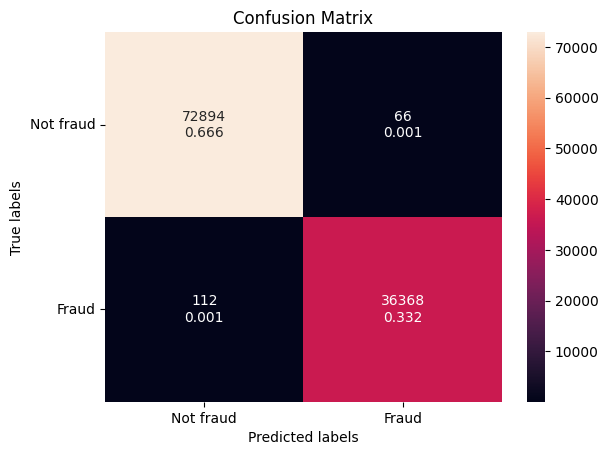

In [19]:
# Initiate stratified k folds
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation with chosen model
y_pred_gscv = cross_val_predict(cv_best_model, X_train_rfecv, y_train_smote, cv = sk_folds)

# Calculate scores
auc_gscv = roc_auc_score(y_train_smote, y_pred_gscv)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_gscv)}, precision: {precision_score(y_train_smote, y_pred_gscv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_gscv, average='macro')}, f1: {f1_score(y_train_smote, y_pred_gscv, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_gscv, 2)}')

# Plot confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_train_smote, y_pred_gscv)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()